In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [26]:
df = pd.read_csv('nacas.csv')
df.head(n=10)

,naca,reynolds,alpha,CL,CD,CDp,CM,Top_Xtr,Bot_Xtr
0,0006,100000,-10.00,-0.5661,0.11269,0.10814,0.0140,1.0,0.0914
1,0006,100000,-9.75,-0.5830,0.10909,0.10461,0.0097,1.0,0.0925
2,0006,100000,-9.50,-0.7037,0.11447,0.10977,0.0241,1.0,0.0814
3,0006,100000,-9.25,-0.6934,0.11087,0.10614,0.0257,1.0,0.0859
4,0006,100000,-9.00,-0.6952,0.10675,0.10207,0.0227,1.0,0.0898
5,0006,100000,-8.75,-0.7078,0.10227,0.09768,0.0146,1.0,0.0921
6,0006,100000,-8.50,-0.7208,0.09688,0.09233,0.0047,1.0,0.0927
7,0006,100000,-8.25,-0.6967,0.09341,0.08887,0.0159,1.0,0.0987
8,0006,100000,-8.00,-0.6997,0.08881,0.08432,0.0114,1.0,0.1029
9,0006,100000,-7.75,-0.7174,0.08268,0.07796,-0.0036,1.0,0.1066


In [17]:
# Vrillage de test : pour un rayon de 5cm va de pi/2 (90°) à 0 (0°)

def f_1(x):
    return (1-x/5) * np.pi/2

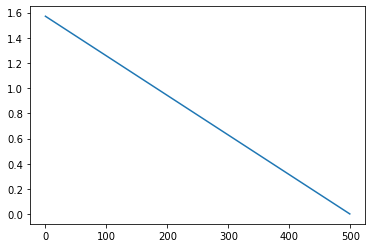

In [22]:
plt.plot(f_1(np.arange(0,5,1/100)))

In [47]:
def drag_lift(naca, rayon_min, rayon_max, f_vrillage, tpm, v_vertical, largeur, pas = 20):
    lift_tot = 0
    drag_tot = 0
    RAYONS = np.arange(rayon_min, rayon_max, (rayon_max-rayon_min)/pas)
    for rayon in RAYONS:
        vitesse_rot = 2 * np.pi * tpm * rayon
        vrillage = f_vrillage(rayon)
        alpha = vrillage - np.arctan(v_vertical/vitesse_rot)


In [62]:
np.arctan(0.

0.09966865249116204

In [42]:
 x = drag_lift(1,0,10,0,0,0)